In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("kmader/helen-eye-dataset")

# print("Path to dataset files:", path)


Path to dataset files: C:\Users\Adarsh Sharma\.cache\kagglehub\datasets\kmader\helen-eye-dataset\versions\2


In [ ]:
pip

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from skimage.filters import frangi
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)


(-0.5, 711.5, 832.5, -0.5)

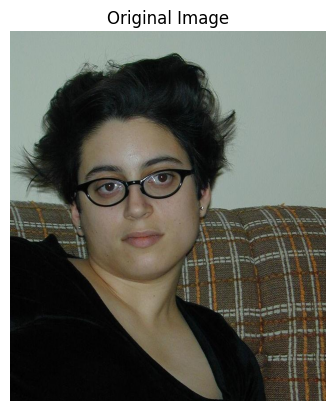

In [3]:
image_path = "C:/Users/Adarsh Sharma/OneDrive/Desktop/major projetc/X-EyeNet/dataset/train_1/train_1/1629243_1.jpg"

image = cv2.imread(image_path)
assert image is not None, "Image not found"

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")


In [4]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True
) as face_mesh:
    results = face_mesh.process(image_rgb)

assert results.multi_face_landmarks, "No face detected"
face_landmarks = results.multi_face_landmarks[0].landmark



(-0.5, 711.5, 832.5, -0.5)

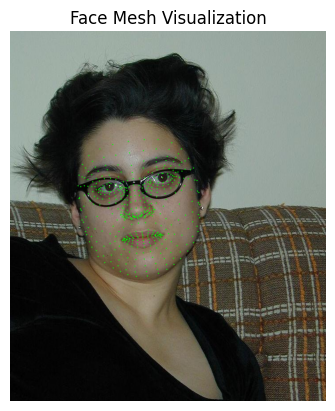

In [5]:
annotated = image_rgb.copy()

h, w, _ = annotated.shape
for lm in face_landmarks:
    x, y = int(lm.x * w), int(lm.y * h)
    cv2.circle(annotated, (x, y), 1, (0, 255, 0), -1)

plt.imshow(annotated)
plt.title("Face Mesh Visualization")
plt.axis("off")


In [6]:
LEFT_EYE = [362, 263, 387, 386, 385, 384, 398]
RIGHT_EYE = [33, 133, 160, 159, 158, 157, 173]



In [7]:
def get_eye_bbox(landmarks, indices, img_shape, pad=10):
    h, w, _ = img_shape
    pts = []
    for idx in indices:
        lm = landmarks[idx]
        pts.append((int(lm.x * w), int(lm.y * h)))

    pts = np.array(pts)
    x_min, y_min = pts.min(axis=0)
    x_max, y_max = pts.max(axis=0)

    return max(0, x_min-pad), max(0, y_min-pad), min(w, x_max+pad), min(h, y_max+pad)


(-0.5, 711.5, 832.5, -0.5)

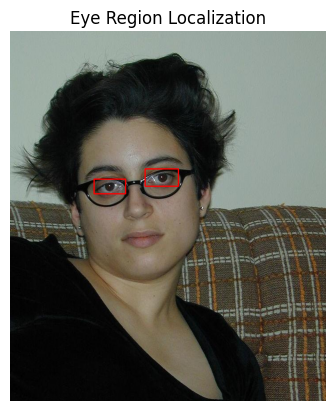

In [8]:
visual = image_rgb.copy()

lx1, ly1, lx2, ly2 = get_eye_bbox(face_landmarks, LEFT_EYE, image.shape)
rx1, ry1, rx2, ry2 = get_eye_bbox(face_landmarks, RIGHT_EYE, image.shape)

cv2.rectangle(visual, (lx1, ly1), (lx2, ly2), (255, 0, 0), 2)
cv2.rectangle(visual, (rx1, ry1), (rx2, ry2), (255, 0, 0), 2)

plt.imshow(visual)
plt.title("Eye Region Localization")
plt.axis("off")


(-0.5, 70.5, 32.5, -0.5)

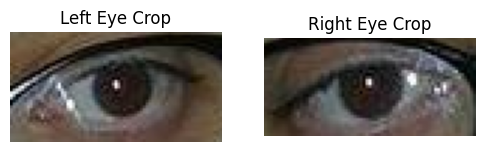

In [9]:
left_eye = image_rgb[ly1:ly2, lx1:lx2]
right_eye = image_rgb[ry1:ry2, rx1:rx2]

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(left_eye)
plt.title("Left Eye Crop")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_eye)
plt.title("Right Eye Crop")
plt.axis("off")


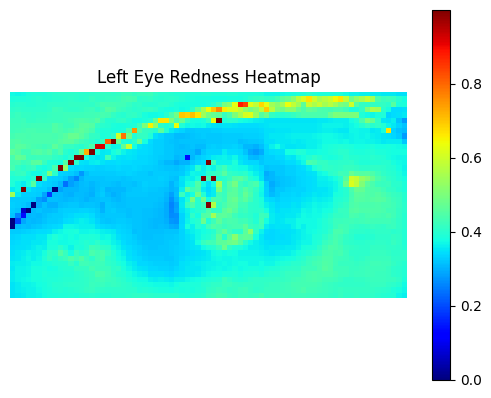

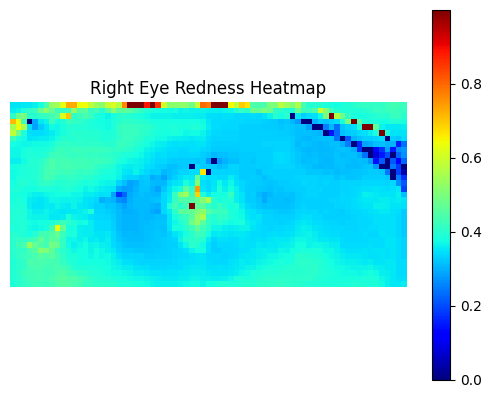

In [10]:
def redness_index(eye):
    eye = eye.astype(np.float32)
    R, G, B = eye[:,:,0], eye[:,:,1], eye[:,:,2]
    return R / (R + G + B + 1e-6)

def plot_redness(eye, title):
    plt.imshow(redness_index(eye), cmap="jet")
    plt.colorbar()
    plt.title(title)
    plt.axis("off")

plot_redness(left_eye, "Left Eye Redness Heatmap")
plt.show()
plot_redness(right_eye, "Right Eye Redness Heatmap")
plt.show()


In [11]:
def yellow_index(eye):
    lab = cv2.cvtColor(eye, cv2.COLOR_RGB2LAB)
    return np.mean(lab[:,:,2])

print("Left Yellow Index:", yellow_index(left_eye))
print("Right Yellow Index:", yellow_index(right_eye))


Left Yellow Index: 134.12102564102565
Right Yellow Index: 131.02475458813487


In [12]:
def compute_EAR(landmarks, indices, img_shape):
    h, w, _ = img_shape
    pts = np.array([[landmarks[i].x*w, landmarks[i].y*h] for i in indices])

    v1 = np.linalg.norm(pts[1] - pts[5])
    v2 = np.linalg.norm(pts[2] - pts[4])
    h_dist = np.linalg.norm(pts[0] - pts[3])

    return (v1 + v2) / (2.0 * h_dist + 1e-6)

EAR_left = compute_EAR(face_landmarks, LEFT_EYE, image.shape)
EAR_right = compute_EAR(face_landmarks, RIGHT_EYE, image.shape)

print("EAR Left:", EAR_left)
print("EAR Right:", EAR_right)
print("EAR Difference:", abs(EAR_left - EAR_right))


EAR Left: 0.9187063798619853
EAR Right: 0.7526112892825546
EAR Difference: 0.16609509057943073


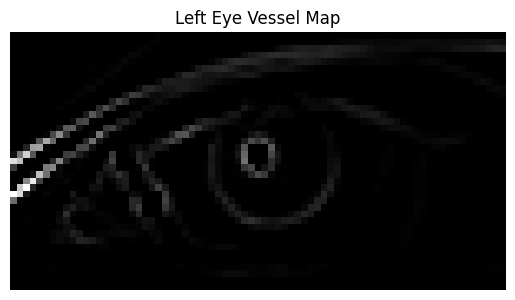

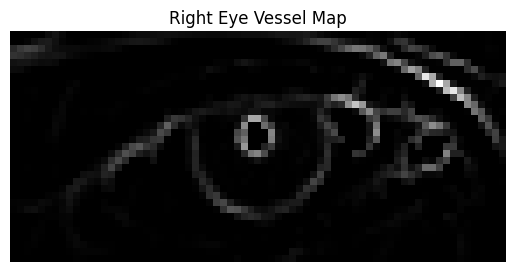

In [13]:
def plot_vessel_map(eye, title):
    vessels = frangi(rgb2gray(eye))
    plt.imshow(vessels, cmap="gray")
    plt.title(title)
    plt.axis("off")

plot_vessel_map(left_eye, "Left Eye Vessel Map")
plt.show()
plot_vessel_map(right_eye, "Right Eye Vessel Map")
plt.show()


In [14]:
features = {
    "EAR_left": EAR_left,
    "EAR_right": EAR_right,
    "EAR_diff": abs(EAR_left - EAR_right),
    "Redness_left": np.mean(redness_index(left_eye)),
    "Redness_right": np.mean(redness_index(right_eye)),
    "Yellow_left": yellow_index(left_eye),
    "Yellow_right": yellow_index(right_eye),
    "label": 1   # TEMP label (change when dataset is ready)
}

df = pd.DataFrame([features])
df


,EAR_left,EAR_right,EAR_diff,Redness_left,Redness_right,Yellow_left,Yellow_right,label
0,0.918706,0.752611,0.166095,0.388743,0.366101,134.121026,131.024755,1


LOOPOVER ALL IMAGES


In [22]:
import cv2
import mediapipe as mp
import numpy as np

mp_face_mesh = mp.solutions.face_mesh

LEFT_EYE = [362, 263, 387, 386, 385, 384, 398]
RIGHT_EYE = [33, 133, 160, 159, 158, 157, 173]

def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True
    ) as face_mesh:
        results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        return None

    face_landmarks = results.multi_face_landmarks[0].landmark
    h, w, _ = image.shape

    def get_eye_bbox(indices):
        pts = []
        for i in indices:
            lm = face_landmarks[i]
            pts.append((int(lm.x * w), int(lm.y * h)))
        pts = np.array(pts)
        x1, y1 = pts.min(axis=0)
        x2, y2 = pts.max(axis=0)
        pad = 10
        return max(0, x1-pad), max(0, y1-pad), min(w, x2+pad), min(h, y2+pad)

    lx1, ly1, lx2, ly2 = get_eye_bbox(LEFT_EYE)
    rx1, ry1, rx2, ry2 = get_eye_bbox(RIGHT_EYE)

    left_eye = image_rgb[ly1:ly2, lx1:lx2]
    right_eye = image_rgb[ry1:ry2, rx1:rx2]

    if left_eye.size == 0 or right_eye.size == 0:
        return None

    def redness_index(eye):
        eye = eye.astype(np.float32)
        R, G, B = eye[:,:,0], eye[:,:,1], eye[:,:,2]
        return np.mean(R / (R + G + B + 1e-6))

    def yellow_index(eye):
        lab = cv2.cvtColor(eye, cv2.COLOR_RGB2LAB)
        return np.mean(lab[:,:,2])

    def compute_EAR(indices):
        pts = np.array([[face_landmarks[i].x*w, face_landmarks[i].y*h] for i in indices])
        v1 = np.linalg.norm(pts[1] - pts[5])
        v2 = np.linalg.norm(pts[2] - pts[4])
        hdist = np.linalg.norm(pts[0] - pts[3])
        return (v1 + v2) / (2.0 * hdist + 1e-6)

    EAR_left = compute_EAR(LEFT_EYE)
    EAR_right = compute_EAR(RIGHT_EYE)

    features = {
        "EAR_left": EAR_left,
        "EAR_right": EAR_right,
        "EAR_diff": abs(EAR_left - EAR_right),
        "Redness_left": redness_index(left_eye),
        "Redness_right": redness_index(right_eye),
        "Yellow_left": yellow_index(left_eye),
        "Yellow_right": yellow_index(right_eye)
    }

    return features


In [28]:
rows = []

IMAGE_DIR = "C:/Users/Adarsh Sharma/OneDrive/Desktop/major projetc/X-EyeNet/dataset/train_1/train_1"  # folder with many images

rows = []
skipped = 0

for img_name in os.listdir(IMAGE_DIR):
    img_path = os.path.join(IMAGE_DIR, img_name)
    features = extract_features_from_image(img_path)

    if features is not None:
        rows.append(features)
    else:
        skipped += 1

df = pd.DataFrame(rows)

print("Total samples:", len(df))
print("Skipped images:", skipped)
df.head()

Total samples: 500
Skipped images: 0


,EAR_left,EAR_right,EAR_diff,Redness_left,Redness_right,Yellow_left,Yellow_right
0,0.925273,0.710768,0.214504,0.414961,0.394250,130.283107,128.583985
1,0.974333,0.644672,0.329660,0.425333,0.430167,138.999310,138.186090
2,0.992434,0.580229,0.412205,0.466663,0.459349,145.378359,146.672751
3,0.903868,0.719821,0.184047,0.648284,0.674602,160.386161,155.572593
4,0.912680,0.702494,0.210185,0.455898,0.478973,141.959229,143.550469


In [32]:
print(df.shape)

(500, 8)


LET CAMPARE TWO MODEL FOR UNLABELED DATA 

In [29]:
from sklearn.preprocessing import StandardScaler

# Drop label if exists
X = df.drop(columns=["label"], errors="ignore")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
kmeans

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)



In [34]:
cluster_stats = df.groupby("kmeans_cluster").mean()
cluster_stats


,EAR_left,EAR_right,EAR_diff,Redness_left,Redness_right,Yellow_left,Yellow_right
kmeans_cluster,,,,,,,
0,0.963046,0.702315,0.260963,0.510267,0.509112,146.485205,146.719305
1,0.926096,0.733251,0.194439,0.387707,0.385430,132.889628,132.724482


In [35]:
# Assume cluster 1 is abnormal based on stats
df["kmeans_abnormal"] = (df["kmeans_cluster"] == 1).astype(int)


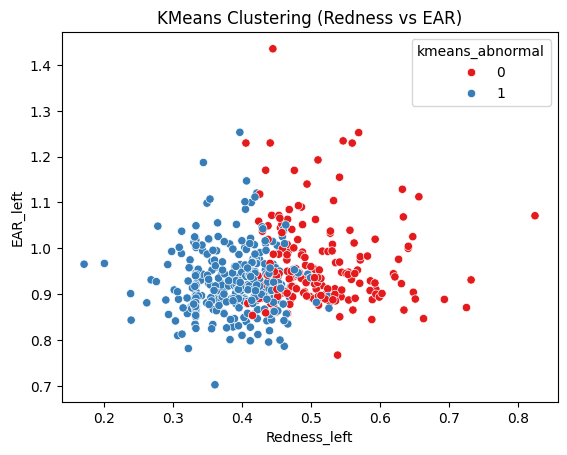

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x=df["Redness_left"],
    y=df["EAR_left"],
    hue=df["kmeans_abnormal"],
    palette="Set1"
)
plt.title("KMeans Clustering (Redness vs EAR)")
plt.show()


isolation forest 

In [40]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.1,   # assume ~10% abnormal
    random_state=42
)

df["iso_score"] = iso.fit_predict(X_scaled)

# -1 = anomaly, +1 = normal
df["iso_abnormal"] = df["iso_score"].map({1: 0, -1: 1})


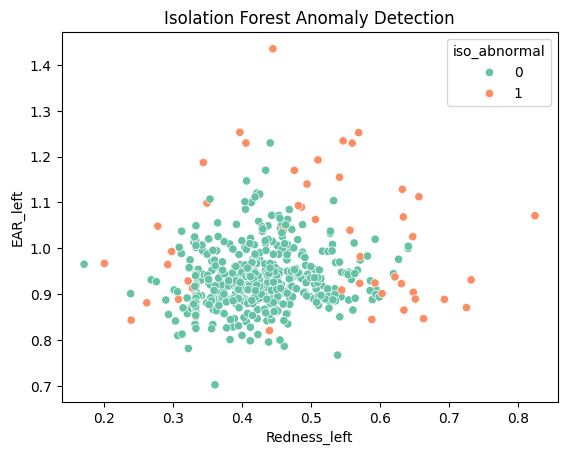

In [41]:
sns.scatterplot(
    x=df["Redness_left"],
    y=df["EAR_left"],
    hue=df["iso_abnormal"],
    palette="Set2"
)
plt.title("Isolation Forest Anomaly Detection")
plt.show()


In [42]:
agreement = (df["kmeans_abnormal"] == df["iso_abnormal"]).mean()
print("Agreement between KMeans and Isolation Forest:", agreement)


Agreement between KMeans and Isolation Forest: 0.336


In [43]:
pd.crosstab(
    df["kmeans_abnormal"],
    df["iso_abnormal"],
    rownames=["KMeans"],
    colnames=["IsolationForest"]
)


IsolationForest,0,1
KMeans,,
0,151,33
1,299,17


In [44]:
comparison = df.groupby("iso_abnormal").mean()
comparison


,EAR_left,EAR_right,EAR_diff,Redness_left,Redness_right,Yellow_left,Yellow_right,kmeans_cluster,kmeans_abnormal,iso_score
iso_abnormal,,,,,,,,,,
0,0.931150,0.723715,0.208394,0.425265,0.423307,137.182212,137.077265,0.664444,0.664444,1.0
1,1.016581,0.705228,0.313659,0.500706,0.499684,144.288094,145.050379,0.340000,0.340000,-1.0


In [45]:
df.groupby("kmeans_abnormal").mean()


,EAR_left,EAR_right,EAR_diff,Redness_left,Redness_right,Yellow_left,Yellow_right,kmeans_cluster,iso_score,iso_abnormal
kmeans_abnormal,,,,,,,,,,
0,0.963046,0.702315,0.260963,0.510267,0.509112,146.485205,146.719305,0.0,0.641304,0.179348
1,0.926096,0.733251,0.194439,0.387707,0.385430,132.889628,132.724482,1.0,0.892405,0.053797


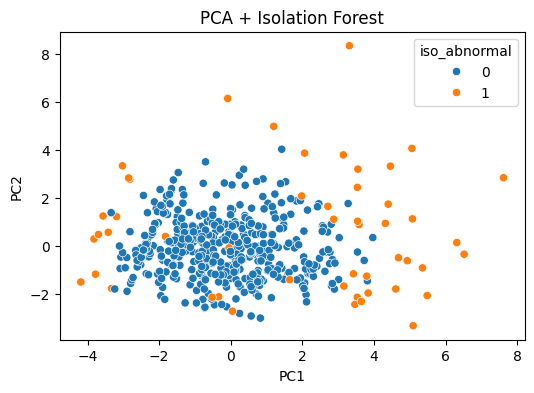

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

plt.figure(figsize=(6,4))
sns.scatterplot(x="PC1", y="PC2", hue="iso_abnormal", data=df)
plt.title("PCA + Isolation Forest")
plt.show()


disaplay sample od eyes